In [1]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
mpl.rcParams['pdf.fonttype'] = 42

In [59]:
dataOp425_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [4]:
dataVis822_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-08-22\1'))

In [6]:
dataVis904_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-04\1'))

In [7]:
dataVis910_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-10\1'))

In [ ]:
dataVis823_ZYE=wfOpto(Path(r'Y:\Subjects\ZYE_0088\2024-08-23\1'))

# b

In [29]:
def wfTrace(ax,data,powers,galvoX,galvoY,y,x,width=50,\
            start=-.3,end=1,xlim=[-.3,6],\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=1,\
            ylabel='Calcium activity (dF/F)',fontsizelegend='xx-small',\
                ypres=True,stim=True,legend=True):
    '''
    traces of activity in response to different powers for one location in one dataset
        data = what dataset
        powrs = list of powers to plot activity for
        galvoX = X location
        galvoY = Y location
        y = y pixel to center ROI around
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    n_samples = round(start*-1+end)*35
    if len(powers)<3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.inferno(np.linspace(.4,1,lenpows))
    pxPowers = []
    sems=[]
    timestamps = np.linspace(start, end, n_samples)
    galvoXTr=np.argwhere(data.galvoX[0:600]==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY[0:600]==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers[0:600]== power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        pxPowers.append(np.mean(trial_activity,axis=0))

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        plt.fill_between(timestamps, \
                power-sems[iP],\
                power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    if legend:
        legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                            columnspacing=0.5,handletextpad=0.3)
        
        # Change the color of the text in the legend to match the line colors
        for text, line in zip(legend.get_texts(), lines):
            text.set_color(line.get_color())
        # Optionally, remove the lines and markers from the legend
        for legend_line in legend.get_lines():
            legend_line.set_linewidth(0)
        for legend_marker in legend.get_patches():
            legend_marker.set_visible(False)

    plt.xlabel(f'Time (s)')
    if ypres:
        plt.ylabel(f'{ylabel}')
    plt.title(f'{title}')
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(.1))
    if stim:
        plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)
    # plt.colorbar(ax,cmap=plt.cm.inferno)

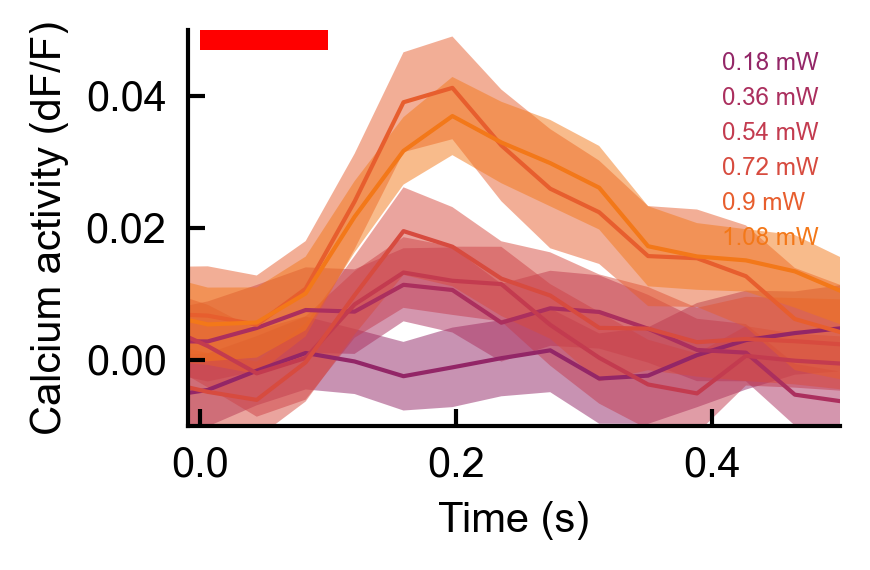

In [37]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
wfTrace(ax,dataVis910_AL35,powers=np.unique(dataVis910_AL35.laserPowers),galvoX=0,galvoY=0,x=400,y=400,width=15,anchor=(1,1),ylim=[-0.01,0.05],start=-0.3,end=1,xlim=[-0.01,0.5])
fig.savefig('paperposterfigs/fig3b_3x2.pdf',dpi=300)

# c

In [41]:
def respQuantLoc(ax,data,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50,title='',ylim=[-0.1,0.04]):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,len(galvoYList)))
    start=0
    end=.5
    time=0.18
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        sems=[]
        galvoYTrs=np.argwhere(data.galvoY==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[:600] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        pxData.append(pxPowers)
        sems_final.append(sems)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for iD,data in enumerate(pxData):
        plt.plot(powerscorr,data,'-o',c=colors[iD],lw=2,label=labels[iD])
        plt.errorbar(powerscorr,data,yerr=sems_final[iD],c=colors[iD],label='_nolabel_')
        plt.scatter(powerscorr,data,label='_nolabel_')
    plt.legend(loc='upper left')
    plt.xlabel("Laser power (mW)")
    plt.ylim(ylim)
    plt.ylabel(f'Activity at peak in Visp (dF/F)')

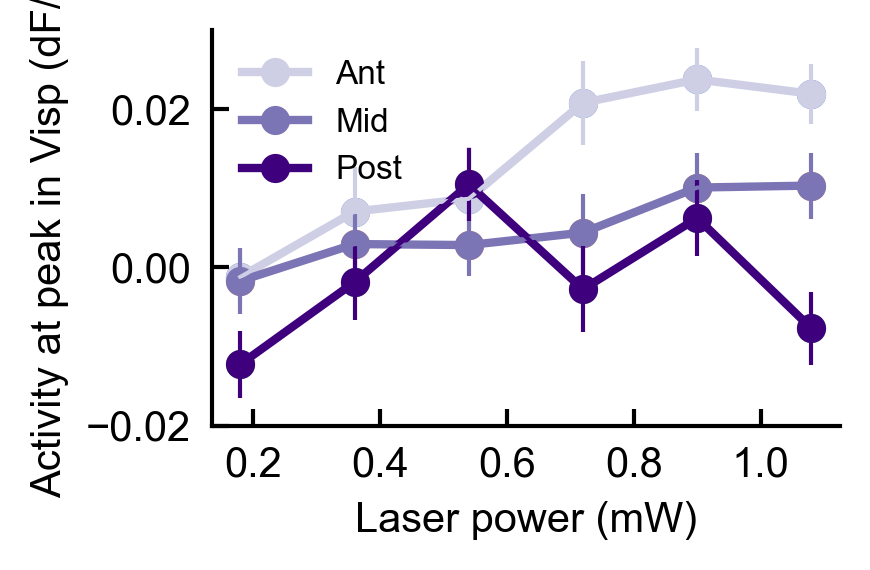

In [44]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
respQuantLoc(ax,dataVis904_AL35,[0,2,3.5],powers=np.unique(dataVis904_AL35.laserPowers),\
             x=100,y=390,time=0.18,width=50,title='',ylim=[-0.02,0.03])
fig.savefig('paperposterfigs/fig3c_3x2.pdf',dpi=300)

# e

In [45]:
def visRespCompare(ax,data,ylim,xlim,exptrs=np.array([0,600,1200]),power=2.5,start=-.3,end=1,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   labels=['No Flicker','Flicker'],legend=True):
    '''
    trace of response in VC compared with and without flicker 
    '''
    xTrace = []
    sems=[]
    colors=['forestgreen','orange']
    labels=['No Flicker','Flicker']
    n_samples=round(start*-1+end)*35
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        xTrace.append(np.mean(trial_activity,axis=0))

    for iP, trace in enumerate(xTrace):
        plt.plot(timestamps,trace, label=labels[iP], color=colors[iP])
        plt.fill_between(timestamps, \
                trace-sems[iP],\
                trace+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    plt.legend()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.ylabel('Activity in Visp (dF/F)',fontsize=10)
    plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,label='_nolegend_')
    plt.legend()
    plt.ylim(ylim)
    plt.xlim(xlim)

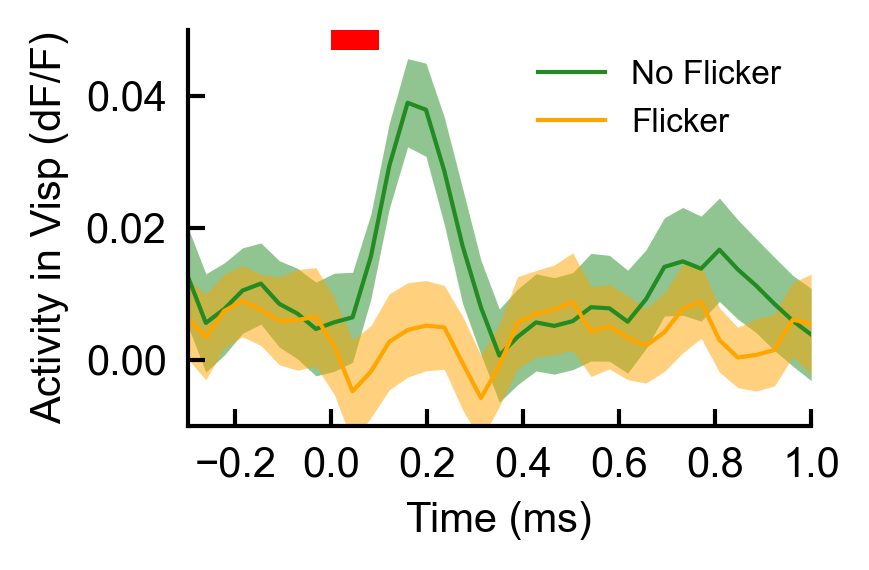

In [49]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
visRespCompare(ax,dataVis910_AL35,[-0.01,0.05],[-.3,1])
fig.savefig('paperposterfigs/fig3f_3x2.pdf',dpi=300)

# f

In [50]:
def visRespQuantCompare(ax,data,ylim,exptrs=np.array([0,600,1200]),time=190,galvoX=0,galvoY=0,x=120,y=380,width=30,labels=['No Flicker','Flicker']):
    '''
    peak of visual activity in VC compared with flicker and no flicker
    '''
    colors=['forestgreen','orange']
    powers = np.unique(data.laserPowers).ravel()
    lenpws = len(powers)
    quantCompare = np.zeros((2,lenpws),dtype=float)
    semsCompare = np.zeros((2,lenpws),dtype=float)
    n_samples=round(0.3+1)*35
    timestamps = np.linspace(-0.3, 1, n_samples)
    labels=['No Flicker', 'Flicker']

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for i in range(2):
        pxPowers=[]
        sems=[]
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        quantCompare[i]=pxPowers
        semsCompare[i]=sems

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for i,peaks in enumerate(quantCompare):
        plt.plot(powerscorr,peaks,'-o',c=colors[i],lw=2,label=labels[i])
        plt.errorbar(powerscorr,peaks,yerr=sems[i],c=colors[i],label='_nolabel_')
        plt.scatter(powerscorr,peaks,c=colors[i],label='_nolabel_')
    plt.legend()
    plt.xlabel("Laser power (mW)")
    plt.ylabel("Peak activity in Visp (dF/F)")
    plt.ylim(ylim)

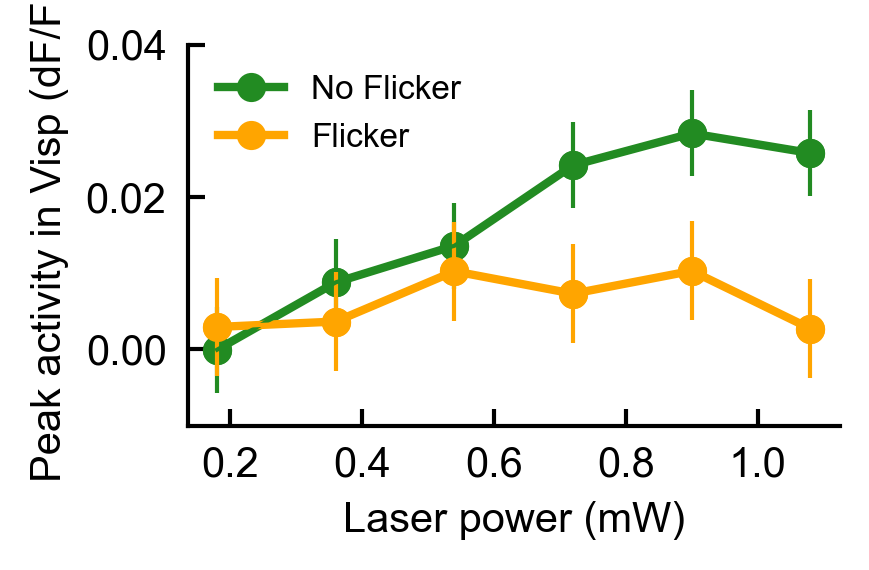

In [55]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
visRespQuantCompare(ax,dataVis904_AL35,[-0.01,0.04],time=0.18,labels=['No Flicker','Flicker'])
fig.savefig('paperposterfigs/fig3e_3x2.pdf',dpi=300)

# h

In [56]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,start=0,end=.5,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    n_samples=round((end-start) * 35)
    timestamps = np.linspace(start,end, n_samples)
    pxPowers = []
    sems=[]
    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
            
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))

    return pxPowers,sems

In [60]:
dataVis=dataVis822_AL35
dataOp=dataOp425_AB32
powers5 = np.unique(dataVis.laserPowers)
vis,visem = powerQuantReturn(data=dataVis,powers=powers5,galvoX=0,galvoY=0,x=120,y=380,time=.18,width=30)
opto,optosem = powerQuantReturn(data=dataOp,powers=np.unique(dataOp.laserPowers),galvoX=0,galvoY=0,x=100,y=200,time=.09,width=50)
interp_func = scipy.interpolate.interp1d(powers5, vis, kind='linear', fill_value='extrapolate')
controlinterp = interp_func(np.unique(dataOp.laserPowers))
mice=[opto,controlinterp]

In [61]:
interp_sem = scipy.interpolate.interp1d(powers5,visem,kind='linear',fill_value='extrapolate')
controlinterpsem = interp_sem(np.unique(dataOp.laserPowers))
sem=[optosem,controlinterpsem]

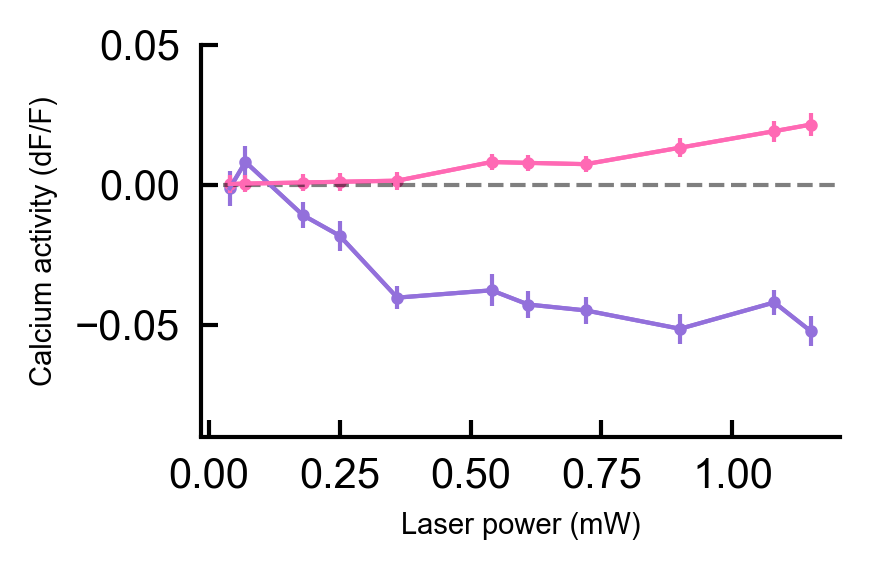

In [63]:
f = plt.figure(figsize=(3,2), dpi=300)
powers11=np.unique(dataOp.laserPowers)
powers = [round(i/2.777777778,2) for i in powers11]
colors=['mediumpurple','hotpink']
labels=['opto','control']


for i,mouse in enumerate(mice):
    plt.plot(powers,mouse,'-o',c=colors[i],lw=1,markersize=2,label=labels[i])

    plt.errorbar(powers,mouse,yerr=sem[i],c=colors[i])

    plt.scatter(powers,mouse,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)

plt.xlabel("Laser power (mW)",fontsize=7)
plt.ylabel("Calcium activity (dF/F)",fontsize=7)
plt.axhline(y=0,color='black',linestyle='--',alpha=0.5)
plt.ylim(-0.09,0.05)
f.savefig('paperposterfigs/fig3h_3x2.pdf',dpi=300)